## Advanced RAG Concept - Data Ingestion Pipeline for PageRAG
### Page-wise Document Processing with LLM Metadata Extraction

Learning Objectives:
- Extract text from PDFs page by page
- Extract metadata using LLM (structured output)
- Store in ChromaDB with rich metadata

#### Real-World Use Cases:
1. Financial Analysis: Process SEC filings (10-K, 10-Q)
2. Legal: Organize contracts and case documents
3. Research: Index academic papers with smart metadata
4. Enterprise: Build searchable document repositories
5. Compliance: Track regulatory documents

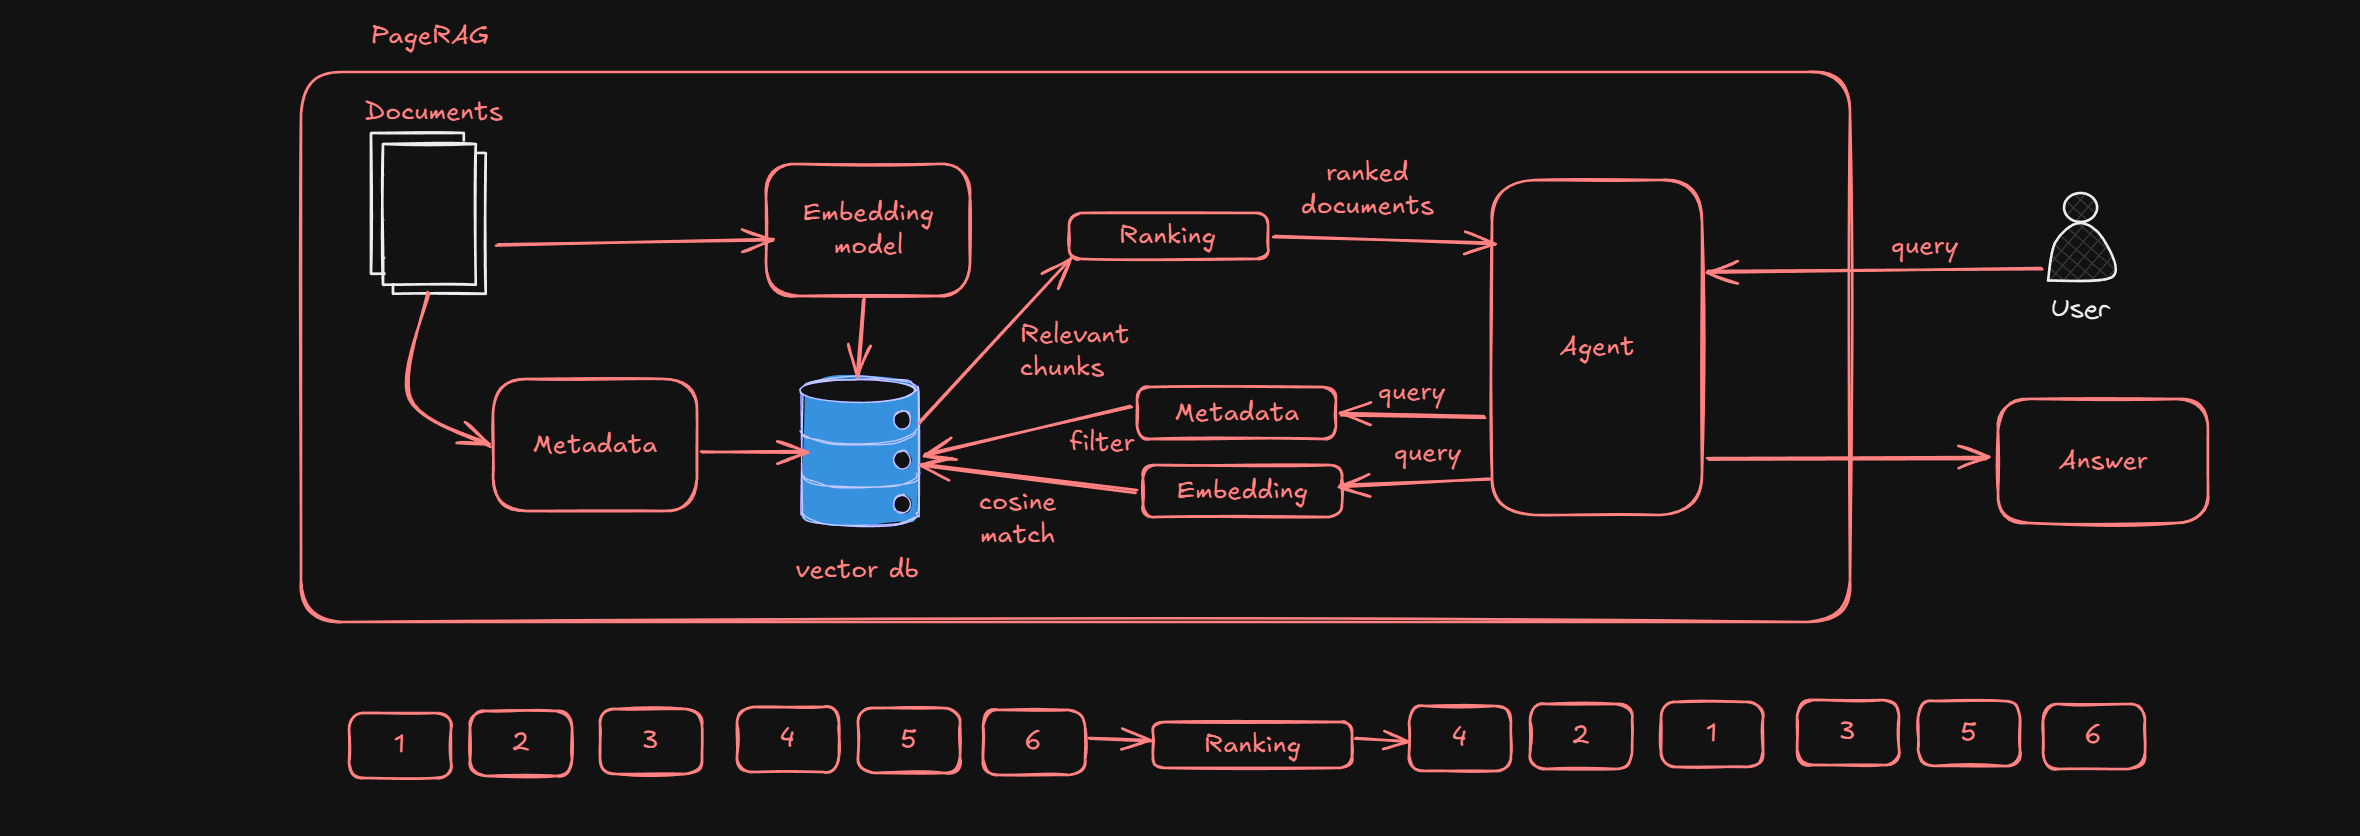

In [1]:
# Advanced RAG - Data Ingestion Pipeline
# Page-wise Document Processing with Filename-based Metadata Extraction
from dotenv import load_dotenv
load_dotenv()

import hashlib
from pathlib import Path

from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings
from langchain_core.documents import Document

from docling.document_converter import DocumentConverter

In [2]:
# configurations
DATA_DIR = "data"
CHROMA_DIR = "./chroma_financial_db"
COLLECTION_NAME = "financial_docs"
EMBEDDING_MODEL = 'nomic-embed-text'
BASE_URL = 'http://localhost:11434'

In [3]:
# ollama pull nomic-embed_text
embeddings= OllamaEmbeddings(model=EMBEDDING_MODEL, base_url=BASE_URL)

vector_store = Chroma(
    collection_name=COLLECTION_NAME,
    embedding_function=embeddings,
    persist_directory=CHROMA_DIR
)

2025-11-12 22:13:00,377 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


### Metadata Extraction

In [4]:
"""
    Extract metadata from filename.
    
    Expected format: {company} {doc_type} {quarter} {year}.pdf
    Examples:
    - amazon 10-k 2024.pdf

    
    Returns:
        dict with company_name, doc_type, fiscal_year, fiscal_quarter
    """

def extract_metadata_from_filename(filename: str) -> dict:

    name = filename.replace('.pdf', '')   
    parts = name.split()

    metadata = {}
    if len(parts) == 4:
        metadata['fiscal_quarter'] = parts[2]
        metadata['fiscal_year'] = int(parts[3])

    else:
        metadata['fiscal_quarter'] = None
        metadata['fiscal_year'] = int(parts[2])

    metadata['company_name'] = parts[0]
    metadata['doc_type'] = parts[1]

    return metadata


In [6]:
extract_metadata_from_filename('amazon 10-k 2023.pdf')
extract_metadata_from_filename('amazon 10-q q1 2024.pdf')

{'fiscal_quarter': 'q1',
 'fiscal_year': 2024,
 'company_name': 'amazon',
 'doc_type': '10-q'}

### Extract text from each page of PDF

In [7]:
def extract_pdf_pages(pdf_path):

    converter = DocumentConverter()

    result = converter.convert(pdf_path)

    page_break = "<!-- page break -->"

    markdown_text = result.document.export_to_markdown(page_break_placeholder=page_break)

    pages = markdown_text.split(page_break)

    return pages



In [8]:
pages = extract_pdf_pages('data/amazon/amazon 10-q q1 2024.pdf')

2025-11-12 22:13:12,878 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-11-12 22:13:12,932 - INFO - Going to convert document batch...
2025-11-12 22:13:12,933 - INFO - Initializing pipeline for StandardPdfPipeline with options hash 4f2edc0f7d9bb60b38ebfecf9a2609f5
2025-11-12 22:13:12,948 - INFO - Loading plugin 'docling_defaults'
2025-11-12 22:13:12,950 - INFO - Registered picture descriptions: ['vlm', 'api']
2025-11-12 22:13:12,965 - INFO - Loading plugin 'docling_defaults'
2025-11-12 22:13:12,969 - INFO - Registered ocr engines: ['auto', 'easyocr', 'ocrmac', 'rapidocr', 'tesserocr', 'tesseract']
2025-11-12 22:13:13,218 - INFO - Accelerator device: 'cuda:0'
[INFO] 2025-11-12 22:13:13,228 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2025-11-12 22:13:13,235 [RapidOCR] download_file.py:60: File exists and is valid: C:\Users\laxmi\anaconda3\envs\ml\Lib\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.onnx
[INFO] 2025-11-12 22:13:13,236 [RapidOCR] main.py:53: 

In [11]:
len(pages)

52

In [14]:
# print(pages[10])

In [15]:
# """Compute SHA-256 hash of file content."""

def compute_file_hash(file_path: str) -> str:
    sha256_hash = hashlib.sha256()
    with open(file_path, "rb") as f:
        for byte_block in iter(lambda: f.read(4096), b""):
            sha256_hash.update(byte_block)
    return sha256_hash.hexdigest()

In [16]:
compute_file_hash('data/amazon/amazon 10-q q1 2024.pdf')

'c08079bc14250c896f3ca151f9a72ecc1ddcb9ca8e5b021539e91af10fae5c4b'

In [17]:
compute_file_hash('data/amazon/amazon 10-q q1 2024 copy.pdf')

'c08079bc14250c896f3ca151f9a72ecc1ddcb9ca8e5b021539e91af10fae5c4b'

In [35]:
# track the processed files
existing_docs = vector_store.get(where={"file_hash": {"$ne": ""}}, include=['metadatas'])
processed_hashes = [m.get('file_hash') for m in existing_docs['metadatas'] if m.get('file_hash')]
processed_hashes = set(processed_hashes)
existing_docs

{'ids': ['7fba2a8d-f660-4d80-b454-fe543f800dda',
  '7012b20f-2e56-4917-ad41-a3a0c4094d8a',
  'b6f16fd0-f8f3-43a8-8085-3650c18da65d',
  'aaa7f226-27a9-4ad0-a951-c6402000ffcc',
  'd7d341b8-287e-4e9b-8253-4719ddf3a14a',
  '0990ce1c-865d-4335-b9cb-af48b3dabe17',
  '5cf3cff7-75f5-42b6-beb1-0273934debf2',
  'f04a2774-243e-469a-a1a3-60354307dd9b',
  '535068ea-6d73-43c7-9b26-f4049faf061e',
  '336854f7-74c1-43fc-8983-ec97b8efa230',
  '128b2818-ccc2-4c53-bad8-a7a9a9071c59',
  '3fc15863-261f-4242-b1d5-437f63b9c921',
  'd177d434-2601-4c9f-a52f-321b95f99a80',
  'd37222ba-a6ad-459b-88d4-851b08780ee9',
  'fd61d579-5f32-41d2-b842-11140e3cc6f8',
  '0ade2743-0317-4dea-b253-6da3ddfef5aa',
  '3ec5c77c-2165-4214-a7e1-a46c465d9629',
  '1bd308c3-47c2-4e8a-a79c-24979bb31679',
  '17820023-8c81-423e-94e4-8e8b201d045e',
  '06a4f181-0426-443f-86b0-f36e2e5cb5e9',
  '6f8dd47a-d3f8-402f-bb85-ea678db9fbfe',
  'a64cf233-f38a-4493-be01-bda66171b9d8',
  '1e8e00e2-4573-4433-9eb7-4b287bbf7c38',
  'cff8a56b-5e53-4d8d-8a89-

In [36]:
processed_hashes

{'6e5549c7b20b0fbc5f482397070a1e85cbf8643c801ff570903f52366b11154f'}

### Documents Ingestion in Vector DB

In [38]:
def ingest_docs_in_vectordb(pdf_path):
    print(f"Processing: {pdf_path.name}")

    file_hash = compute_file_hash(pdf_path)
    if file_hash in processed_hashes:
        print(f"[SKIP] already processed: {pdf_path}")
        return 

    pages = extract_pdf_pages(pdf_path)

    file_metadata = extract_metadata_from_filename(pdf_path.name)

    processed_pages = []

    for page_num, page_text in enumerate(pages, start=1):
        metadata_dict = file_metadata.copy()
        metadata_dict['page'] = page_num
        metadata_dict['file_hash'] = file_hash
        metadata_dict['source_file'] = pdf_path.name

        doc = Document(page_content=page_text, metadata=metadata_dict)

        processed_pages.append(doc)

    
    vector_store.add_documents(documents=processed_pages)



In [39]:
data_path = Path(DATA_DIR)
pdf_files = list(data_path.rglob("*.pdf"))
pdf_files[:3]

[WindowsPath('data/amazon/amazon 10-k 2023.pdf'),
 WindowsPath('data/amazon/amazon 10-k 2024.pdf'),
 WindowsPath('data/amazon/amazon 10-q q1 2024.pdf')]

In [ ]:
for pdf_path in pdf_files:
    ingest_docs_in_vectordb(pdf_path)

In [42]:
vector_store._collection.count()

1270

In [43]:
vector_store.get(where={"company_name": "amazon"}, limit=2)

{'ids': ['7fba2a8d-f660-4d80-b454-fe543f800dda',
  '7012b20f-2e56-4917-ad41-a3a0c4094d8a'],
 'embeddings': None,
 'documents': ["## UNITED STATES\n\n## SECURITIES AND EXCHANGE COMMISSION\n\nWashington, D.C. 20549\n\n\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\n\nFORM 10-K\n\n\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\n\n(Mark One)\n\n- [x] ☒ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\n\nFor the fiscal year ended December 31, 2023\n\nor\n\n- [ ] ☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\n\nFor the transition period from            to             .\n\nCommission File No. 000-22513\n\n\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\n\n## AMAZON.COM, INC.\n\n(Exact name of registrant as specified in its charter)

In [48]:
results = vector_store.search("What is Tesla's revenue for Q1 2024", search_type="similarity")

2025-11-13 10:13:17,790 - INFO - HTTP Request: POST http://localhost:11434/api/embed "HTTP/1.1 200 OK"


In [49]:
results

[Document(id='fe910123-8392-4df8-87ca-61af372594da', metadata={'fiscal_year': 2023, 'company_name': 'apple', 'doc_type': '8-k', 'page': 5, 'fiscal_quarter': 'q4', 'source_file': 'apple 8-k q4 2023.pdf', 'file_hash': 'bfb57cd34d8c3d9f650b54f4914d712f7d88d57aa7b374886e23101da3228356'}, page_content="\n\n## Apple reports first quarter results\n\n## Services revenue reaches new all-time record\n\n## EPS up 16 percent to new all-time high\n\nCUPERTINO, CALIFORNIA - Apple  today announced financial results for its fiscal 2024 first quarter ended December 30, 2023. The Company posted quarterly revenue of $119.6 billion, up 2 percent year over year, and quarterly earnings per diluted share of $2.18, up 16 percent year over year. ®\n\n'Today Apple is reporting revenue growth for the December quarter fueled by iPhone sales, and an all-time revenue record in Services,' said Tim Cook, Apple's CEO. 'We are pleased to announce that our installed base of active devices has now surpassed 2.2 billion, 